In [4]:
import pandas as pd
import os
import cv2
import pickle
import random
import numpy as np
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Import & Parse XML data
Much of the code for preprocessing is from Farhan Sadaf. Located [here](https://github.com/FarhanSadaf/face-mask-detection/blob/master/1_data-preprocessing.ipynb).

In [2]:
BASE_DIR = os.getcwd()
image_dir = os.path.join(BASE_DIR, 'data', 'images')
annot_dir = os.path.join(BASE_DIR, 'data', 'annotations')

In [3]:
label2category = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
category2label = {v: k for k, v in label2category.items()}
data_list = []

for root, dirs, files in os.walk(annot_dir):
    for file in files:
        tree = et.parse(os.path.join(root, file))
        data = {'path': None, 'objects': []}
        data['path'] = os.path.join(image_dir, tree.find('filename').text)
        for obj in tree.findall('object'):
            label = label2category[obj.find('name').text]
            # top left co-ordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            # bottom right co-ordinates
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            data['objects'].append([label, xmin, ymin, xmax, ymax])
        data_list.append(data)

print('Total images :', len(data_list))

Total images : 853


## Draw Bounding Boxes

In [4]:
def show_image(data, index):
    #Read image according to index
    img = cv2.imread(data[index]['path'])

    #Draw bounding box
    for (category, xmin, ymin, xmax, ymax) in data[index]['objects']:
        # Change box color based on label & draw
        if category == 0:
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
        elif category == 1:
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
        else:
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 255), 1)

        #Add label text    
        cv2.putText(img, str(category), (xmin+2, ymin-3), cv2.FONT_HERSHEY_SIMPLEX, 0.38, (255,255,255), 2)

    # Show image
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

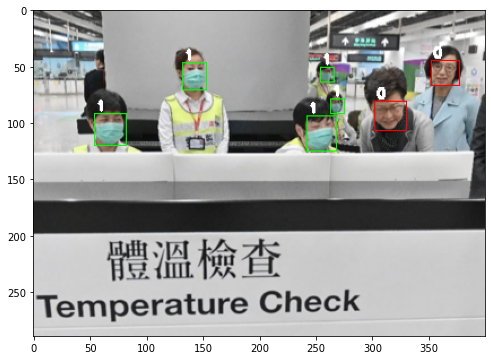

In [5]:
show_image(data_list, 23)

## Train Test Split

In [6]:
#Split on number of faces, b/c treating each face as its own image

face_count = 0
for image in data_list:
    for face in image['objects']:
        face_count += 1

print("Total faces: " + str(face_count))

Total faces: 4072


In [7]:
# 75% vs 25% train test split
train_size = int(4072 * .75)
test_size = face_count - train_size

In [8]:
train_list = []
face_train_count = 0
k=1

while face_train_count < train_size:
    face_train_count = 0
    k += 1
    train_list = random.sample(data_list, k)
    
    for index in range(len(train_list)):
        face_train_count += len(train_list[index]['objects'])

In [9]:
test_list = []

for element in data_list:
    if element not in train_list:
        test_list.append(element)

In [10]:
face_test_count = 0

for index in range(len(test_list)):
    face_test_count += len(test_list[index]['objects'])

In [11]:
print(face_train_count)
print(face_test_count)

3129
943


In [12]:
def mask_type_count(data):
    correct = 0
    incorrect = 0
    no_mask = 0
    
    for element in data:
        for object_ in element['objects']:
            if object_[0] == 0:
                no_mask += 1
            elif object_[0] == 1:
                correct += 1
            else:
                incorrect += 1
    
    total = no_mask + correct + incorrect
    correct_p = correct / total * 100
    incorrect_p = incorrect / total * 100
    no_mask_p = no_mask / total * 100
    
    print('% with correctly worn masks: ' + str(round(correct_p)))
    print('% with no masks: ' + str(round(no_mask_p)))
    print('% with incorrectly worn masks: ' + str(round(incorrect_p)))

In [19]:
mask_type_count(train_list)

% with correctly worn masks: 79
% with no masks: 18
% with incorrectly worn masks: 3


In [20]:
mask_type_count(test_list)

% with correctly worn masks: 81
% with no masks: 16
% with incorrectly worn masks: 3


## Train-Test Split

Crop & save face images in train/test directory based on mask label

In [47]:
#Save faces from image as separate images.  Separate into folders based on label

def save_face_img(data, index, train):
    
    #Read image according to index
    img = cv2.imread(data[index]['path'])
    
    #Get image name without file extension
    img_name = data[index]['path'].split('/')[-1][:-4]
    count = 0
    
    #Save faces as new images
    for (category, xmin, ymin, xmax, ymax) in data[index]['objects']:
        #Get dimensions of face image
        roi = img[ymin:ymax, xmin:xmax]
        
        #Change file location based on label
        if category == 0:
            label = '0_no_mask/'
        elif category == 1:
            label = '1_correct/'
        else:
            label = '2_incorrect/'
        
        #Save image if training set
        if train:
            path = '/Volumes/My Passport for Mac 5TB/mask_detection/data/train_faces/'
            file_name = path + label + img_name + '_' + str(count) + '.png'
            cv2.imwrite(file_name, roi)
            count += 1
        
        #Save image if test set
        else:
            
            path = '/Volumes/My Passport for Mac 5TB/mask_detection/data/test_faces/'
            file_name = path + label + img_name + '_' + str(count) + '.png'
            cv2.imwrite(file_name, roi)
            count += 1

In [48]:
for i in range(len(train_list)):
    save_face_img(train_list, i, True)
for i in range(len(test_list)):
    save_face_img(test_list, i, False)

## Prepare Data For Modeling

In [ ]:
#Convolutional neural network

# Think will treat contents of each bounding box as its own image.  Aggregate all bounding box images as training set

In [5]:
face_train_count = sum(len(files) for _, _, files in os.walk("data/train_faces")) - 1
face_test_count = sum(len(files) for _, _, files in os.walk("data/test_faces")) - 1

In [6]:
face_test_count

943

In [7]:
face_train_count

3130

In [8]:
# Directory path
train_data_dir = 'data/train_faces'
test_data_dir = 'data/test_faces'

# Get all the data in the test directory (943 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=face_test_count)

# Get all the data in the train directory (3129 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=face_train_count)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 943 images belonging to 3 classes.
Found 3129 images belonging to 3 classes.


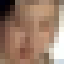

In [9]:
#Preview some images
array_to_img(train_images[23])

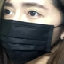

In [10]:
array_to_img(test_images[73])

## Reshape Image Data

In [11]:
#See data shape
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(3129, 64, 64, 3)
(3129, 3)
(943, 64, 64, 3)
(943, 3)


In [12]:
#Remove labels from image data
train_images = train_images[:, :, :, 0]
test_images = test_images[:, :, :, 0]

#Check dimensions
print(np.shape(train_images))
print(np.shape(test_images))

(3129, 64, 64)
(943, 64, 64)


In [13]:
# Reshape the train images 
train_img_unrow = train_images.reshape(3129, 4096)

# Preview the shape of train_img_unrow
np.shape(train_img_unrow)

(3129, 4096)

In [14]:
# Reshape the test images 
test_img_unrow = test_images.reshape(943, 4096)

# Preview the shape of test_img_unrow
np.shape(test_img_unrow)

(943, 4096)

In [15]:
X_train = train_img_unrow
X_test = test_img_unrow

#Normalize image data
X_train /= 255
X_test /= 255

## Reshape Label Data

In [17]:
train_generator.class_indices

{'0_no_mask': 0, '1_correct': 1, '2_incorrect': 2}

This shows that in the train_labels data structure, the 1st column represents no mask.  The 2nd represents correctly worn mask.  The 3rd represents an incorrectly worn mask.

In [18]:
y_train = train_labels
y_test = test_labels

In [19]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

## Train Model

In [20]:
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(4096,)))
model_1.add(Dense(3, activation='softmax'))

In [21]:
model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [22]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 262,403
Trainable params: 262,403
Non-trainable params: 0
_________________________________________________________________


In [33]:
results_1 = model_1.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

Train on 3129 samples, validate on 943 samples
Epoch 1/25
3129/3129 [==============================] - 0s 56us/sample - loss: 0.4651 - acc: 0.8066 - val_loss: 0.4990 - val_acc: 0.7964
Epoch 2/25
3129/3129 [==============================] - 0s 44us/sample - loss: 0.4363 - acc: 0.8258 - val_loss: 0.5017 - val_acc: 0.8155
Epoch 3/25
3129/3129 [==============================] - 0s 41us/sample - loss: 0.4466 - acc: 0.8185 - val_loss: 0.4635 - val_acc: 0.8293
Epoch 4/25
3129/3129 [==============================] - 0s 42us/sample - loss: 0.4469 - acc: 0.8194 - val_loss: 0.5138 - val_acc: 0.8123
Epoch 5/25
3129/3129 [==============================] - 0s 42us/sample - loss: 0.4282 - acc: 0.8255 - val_loss: 0.4545 - val_acc: 0.8271
Epoch 6/25
3129/3129 [==============================] - 0s 49us/sample - loss: 0.4226 - acc: 0.8335 - val_loss: 0.4540 - val_acc: 0.8240
Epoch 7/25
3129/3129 [==============================] - 0s 43us/sample - loss: 0.4404 - acc: 0.8245 - val_loss: 0.4841 - val_acc: 0

In [34]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

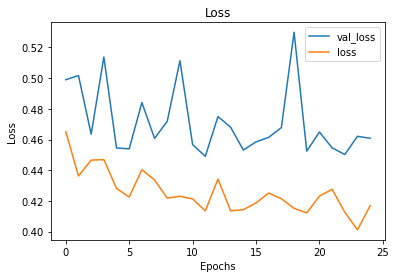

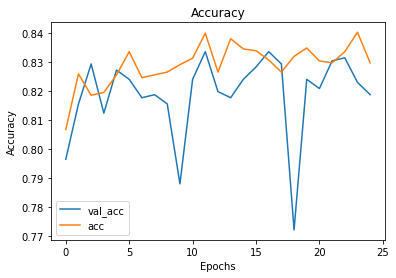

In [35]:
visualize_training_results(results_1)

In [46]:
model_2 = Sequential()
model_2.add(Dense(64, activation='relu', input_shape=(4096,)))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(3, activation='softmax'))

In [47]:
model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
results_2 = model_2.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))

Train on 3129 samples, validate on 943 samples
Epoch 1/50
3129/3129 [==============================] - 0s 144us/sample - loss: 0.6363 - acc: 0.7779 - val_loss: 0.5875 - val_acc: 0.8070
Epoch 2/50
3129/3129 [==============================] - 0s 44us/sample - loss: 0.6042 - acc: 0.7897 - val_loss: 0.5791 - val_acc: 0.8070
Epoch 3/50
3129/3129 [==============================] - 0s 49us/sample - loss: 0.5913 - acc: 0.7897 - val_loss: 0.5650 - val_acc: 0.8070
Epoch 4/50
3129/3129 [==============================] - 0s 44us/sample - loss: 0.5799 - acc: 0.7897 - val_loss: 0.5586 - val_acc: 0.8070
Epoch 5/50
3129/3129 [==============================] - 0s 47us/sample - loss: 0.5700 - acc: 0.7897 - val_loss: 0.5509 - val_acc: 0.8070
Epoch 6/50
3129/3129 [==============================] - 0s 41us/sample - loss: 0.5626 - acc: 0.7897 - val_loss: 0.5472 - val_acc: 0.8070
Epoch 7/50
3129/3129 [==============================] - 0s 44us/sample - loss: 0.5560 - acc: 0.7897 - val_loss: 0.5428 - val_acc: 

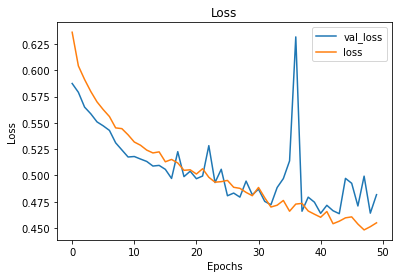

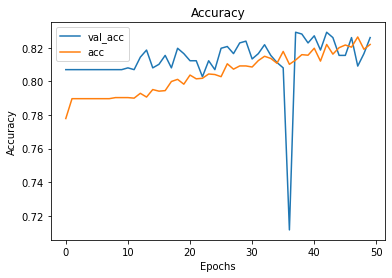

In [48]:
visualize_training_results(results_2)

In [ ]:
#Create more w/out mask & incorrect mask data to address class imbalance

In [ ]:
#Add ability to detect faces without bounding boxes